<a href="https://colab.research.google.com/github/keita-h/caltech_birds2011_Class/blob/main/caltech_birds2011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout,Input,DepthwiseConv2D,Concatenate,Add,Activation
from tensorflow.keras import Model,Sequential 

In [2]:
dataset,info = tfds.load('caltech_birds2011',split=['train','test'],with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2011/0.1.1.incomplete5CSVW4/caltech_birds2011-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2011/0.1.1.incomplete5CSVW4/caltech_birds2011-test.tfrecord


Dataset caltech_birds2011 downloaded and prepared to /root/tensorflow_datasets/caltech_birds2011/0.1.1. Subsequent calls will reuse this data.


In [3]:
train_ds=dataset[0]
test_ds=dataset[1]

In [4]:
@tf.function
def edit_ds(data):
    image=tf.image.resize(data["image"],[128,128])
    mask=tf.image.resize(data["segmentation_mask"],[128,128],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask=tf.cast(mask,tf.float32)/255.0

    return tf.cast(image,tf.float32)/255.0,mask

def edit_ex_ds(data):
    image=tf.image.resize(data["image"],[128,128])
    mask=tf.image.resize(data["segmentation_mask"],[128,128],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    if tf.random.uniform(())>0.5:
        image=tf.image.flip_left_right(image)
        mask=tf.image.flip_left_right(mask)
    else:
        image=tf.image.flip_up_down(image)
        mask=tf.image.flip_up_down(mask)
    
    return tf.cast(image,tf.float32)/255.0,tf.cast(mask,tf.float32)/255.0

In [5]:
train_edit=train_ds.map(edit_ds)
train_ex=train_ds.map(edit_ex_ds)
test_edit=test_ds.map(edit_ds)

In [6]:
for i in train_edit.take(1):
    sample_img,sample_mask=i[0],i[1]

In [7]:
BATCH_SIZE=16
BUFFER_SIZE=1000

In [8]:
train=train_edit.concatenate(train_ex).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test=test_edit.batch(BATCH_SIZE)

In [9]:
vgg=tf.keras.applications.VGG16(include_top=False,input_shape=(128,128,3))

58892288/58889256 [==============================] - 1s 0us/step


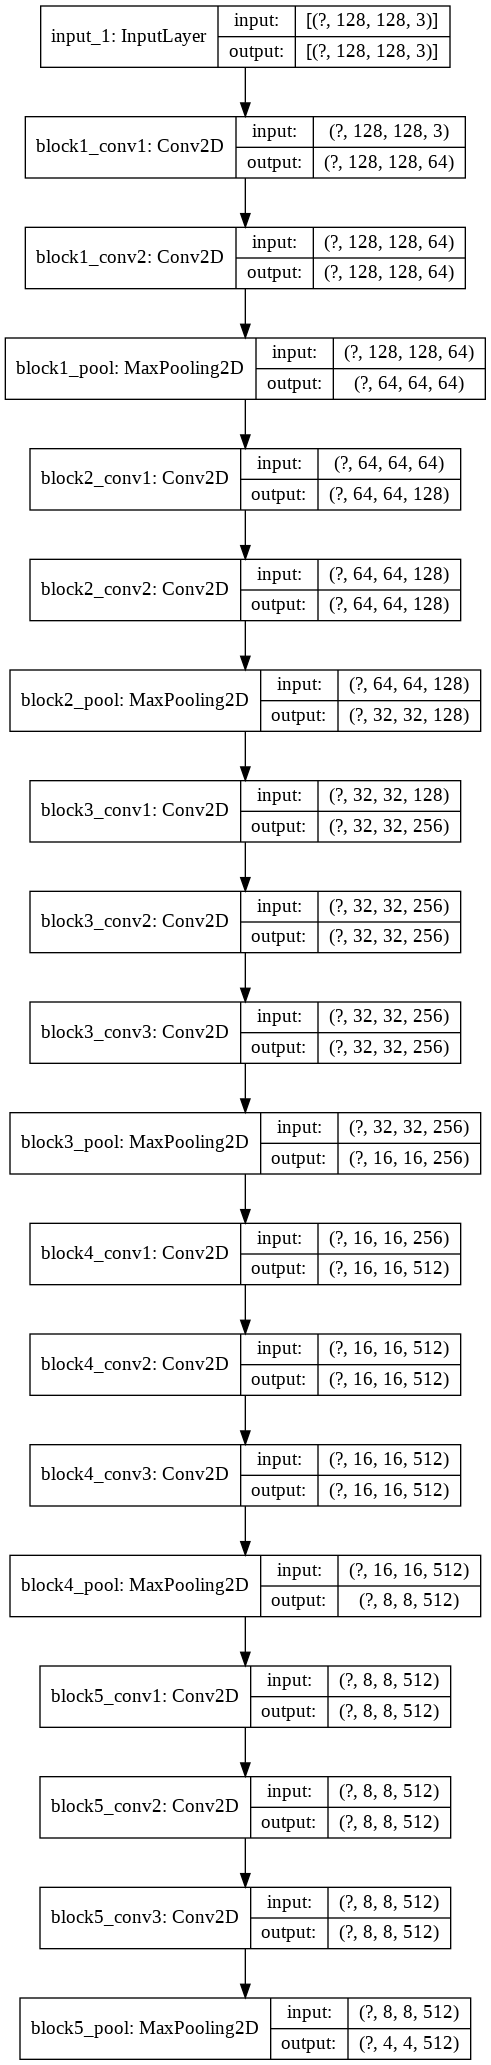

In [10]:
tf.keras.utils.plot_model(vgg,show_shapes=True)

In [11]:
down_names=[
            'block2_conv2',
            'block3_conv3',
            'block4_conv3',
            'block5_conv3',
            'block5_pool',
]
down_layers=[vgg.get_layer(name=name).output for name in down_names]

In [12]:
down_layers

[<tf.Tensor 'block2_conv2/Relu:0' shape=(None, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'block3_conv3/Relu:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'block4_conv3/Relu:0' shape=(None, 16, 16, 512) dtype=float32>,
 <tf.Tensor 'block5_conv3/Relu:0' shape=(None, 8, 8, 512) dtype=float32>,
 <tf.Tensor 'block5_pool/MaxPool:0' shape=(None, 4, 4, 512) dtype=float32>]

In [13]:
down_stack=Model(vgg.input,down_layers)

In [14]:
down_stack.trainable=False

In [15]:
def down_model(filters,kernel_size,input_shape,apply_batchnorm=True):
    inputs=Input(shape=input_shape)
    x=inputs
    x=Conv2D(filters,kernel_size,strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)(x)
    if apply_batchnorm:
        x=BatchNormalization()(x)
    x=Activation('relu')(x)

    x_1=Conv2D(filters,kernel_size,padding='same',strides=2,kernel_initializer='he_normal',use_bias=False)(x)
    x_1=BatchNormalization()(x_1)
    x_1=Activation('relu')(x_1)
    x_1=Conv2D(filters+2,kernel_size,padding='same',kernel_initializer='he_normal',use_bias=False)(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Activation('relu')(x_1)
    x_1=Conv2D(filters,kernel_size,padding='same',kernel_initializer='he_normal',use_bias=False)(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Activation('relu')(x_1)
    x_1=tf.keras.layers.UpSampling2D()(x_1)

    add=Add()([x,x_1])

    return Model(inputs=inputs,outputs=add)

In [16]:
def up_model(filters,kernel_size,rate=0.5,dropout=False):
    model=Sequential()
    model.add(Conv2DTranspose(filters,kernel_size,strides=2,padding='same',use_bias=False,kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    if dropout:
        model.add(Dropout(rate))
    return model

In [17]:
up_models=[
           
           up_model(512,3,dropout=True),
           up_model(512,3,dropout=True),
           up_model(256,3,dropout=True),
        #    up_model(256,3),
           up_model(128,3),
           up_model(64,3)
]

In [18]:
up_models

In [19]:
def create_model(out_put):
    inputs=Input(shape=(128,128,3))
    x=inputs

    skips=[]
    skips=down_stack(x)
    x=skips[-1]
    skips=reversed(skips[:-1])

    for up,s in zip(up_models,skips):
        x=up(x)
        x=Concatenate()([x,s])
    
    last=Conv2DTranspose(out_put,4,strides=2,padding='same',use_bias=False)(x)

    return Model(inputs=inputs,outputs=last)

In [20]:
model=create_model(3)

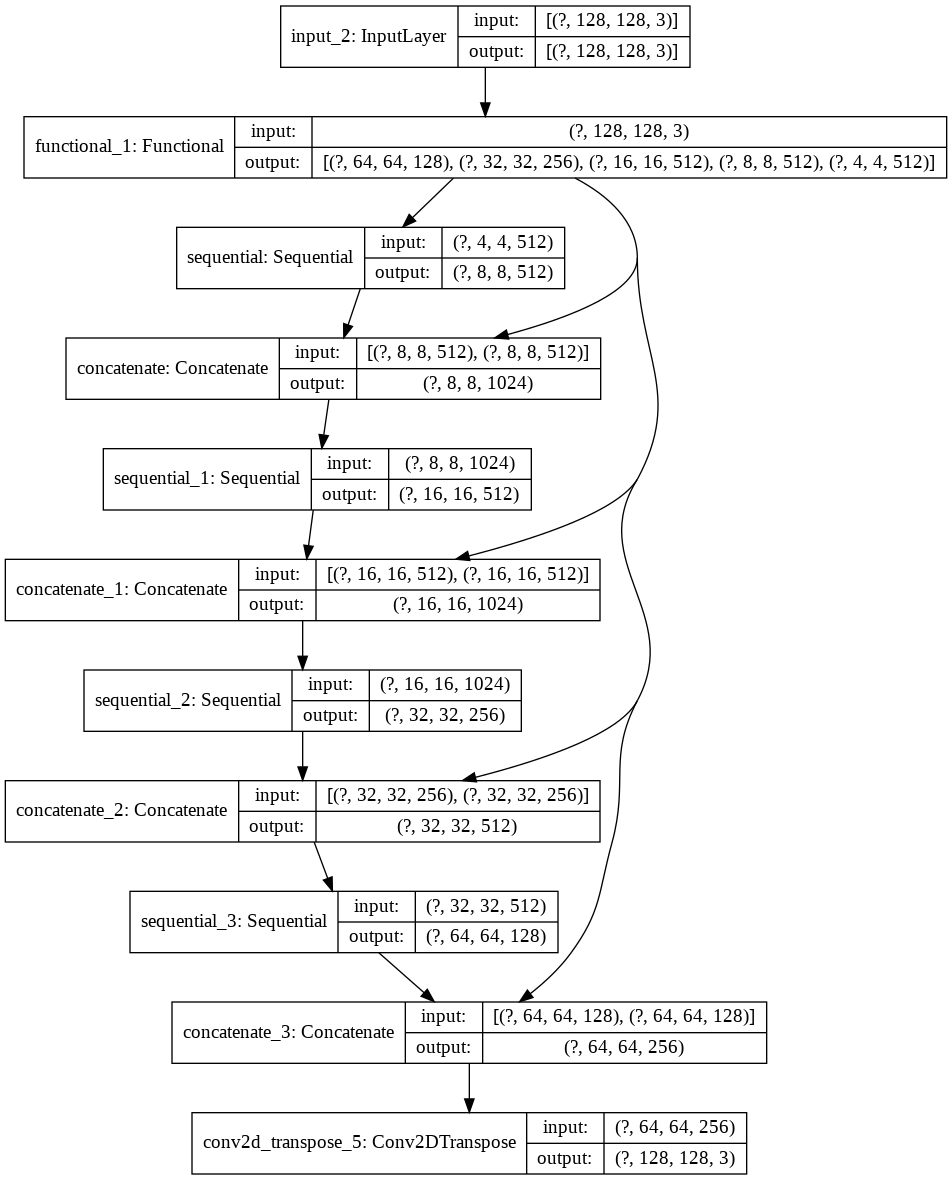

In [21]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [22]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
                 pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_img, sample_mask,create_mask(model.predict(sample_img[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

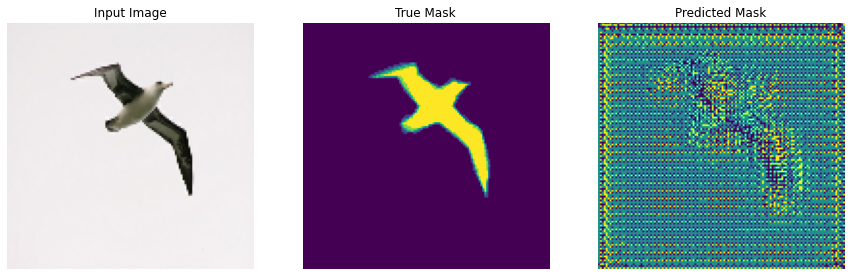

In [23]:
show_predictions()

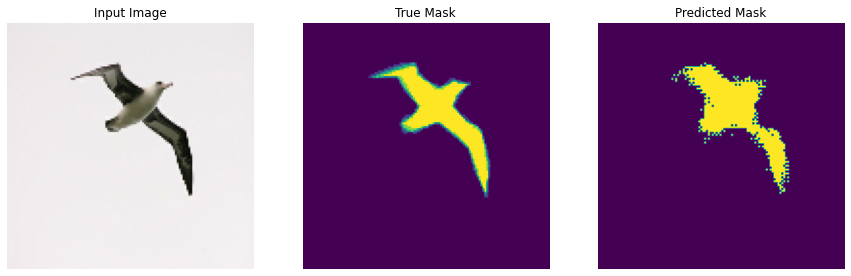


Sample Prediction after epoch 6

10/10 [==============================] - 99s 10s/step - loss: 0.1614 - accuracy: 0.8971 - val_loss: 0.5104 - val_accuracy: 0.8507
Epoch 7/10
 4/10 [===========>..................] - ETA: 28s - loss: 0.1933 - accuracy: 0.8697

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.fit(
    train,
    validation_data=test,
    epochs=10,
    steps_per_epoch=10,
    validation_steps=10,
    callbacks=[DisplayCallback(),
               tf.keras.callbacks.EarlyStopping(patience=10),
               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=0.0001, mtttttttggin_delta=0.01, verbose=1)
               ]
    )